In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from shap import plots, Explanation, DeepExplainer
from sklearn.preprocessing import StandardScaler
import time
import shap
from tqdm import tqdm
import pickle
from sklearn.cluster import KMeans
from utils import *
from mlp import MLP
import torch
from yellowbrick.model_selection import LearningCurve
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Here I force the model to run on cpu since it's a small one is goes faster on a cpu then a gpu
device = 'cpu'

In [3]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [4]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


ricordarsi di fare fit una volta sola per tutti i dati e poi usare transform dove serve

In [5]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

In [6]:
model = MLP(epoch=320, verbose=False, out_neurons=6, n_features=79)

le = LabelEncoder()
le.fit(ds['traffic_category'])

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], le.transform(ds['traffic_category']))

scaled_X_res = scaler.transform(X_res)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

In [8]:
if False:
    cv = 10
    visualizer = LearningCurve(estimator=model, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="mlp_data/learning_curve.png")


In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(scaled_X_res, y_res)

5

In [10]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(scaled_X_res, y_res)):
    print(f"Fold {i}:")
    model.fit(scaled_X_res[train_index], y_res[train_index])
    y_predicted_train = model.predict(scaled_X_res[train_index])
    y_predicted_test = model.predict(scaled_X_res[test_index])
    train_f1 = metrics.f1_score(y_res[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
No improvement for 10 epochs, stopping.
Execution time:  82.25360774993896
Train F1: 0.8190
Test F1: 0.8181
Fold 1:
No improvement for 10 epochs, stopping.
Execution time:  78.01105761528015
Train F1: 0.8418
Test F1: 0.8439
Fold 2:
No improvement for 10 epochs, stopping.
Execution time:  18.82524871826172
Train F1: 0.6712
Test F1: 0.6678
Fold 3:
No improvement for 10 epochs, stopping.
Execution time:  12.932472229003906
Train F1: 0.7180
Test F1: 0.7193
Fold 4:
No improvement for 10 epochs, stopping.
Execution time:  14.600988388061523
Train F1: 0.8232
Test F1: 0.8311
Average Train F1: 0.7746
Average Test F1: 0.7760


In [11]:
model.fit(X_train, y_train)

No improvement for 10 epochs, stopping.
Execution time:  74.64605474472046


In [12]:
y_predicted_test = model.predict(X_test)
y_predicted_train = model.predict(X_train)

In [13]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [14]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.862683,0.867411
1,PRECISION,0.856085,0.861754
2,RECALL,0.862683,0.867411
3,F1 SCORE,0.853823,0.859364


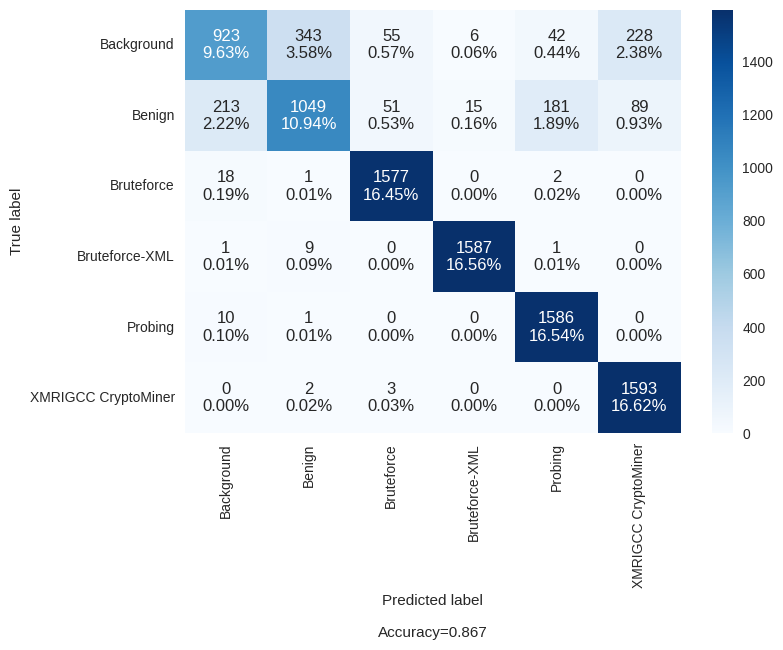

In [15]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(le.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [16]:
scaled_X_train = scaler.transform(X_train)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [17]:
cluster_centers = KMeans(n_clusters=1000, random_state=0).fit(scaled_X_train).cluster_centers_
cluster_centers = torch.from_numpy(cluster_centers.astype(np.float32)).to(device)

foreground = shap.sample(X_train, 1000)
foreground_tensor = torch.from_numpy(foreground.astype(np.float32)).to(device)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [18]:
%%time

explainer = DeepExplainer(model, cluster_centers)
sv = explainer.shap_values(foreground_tensor)

CPU times: user 18min 32s, sys: 1.36 s, total: 18min 33s
Wall time: 2min 19s


# Background shap

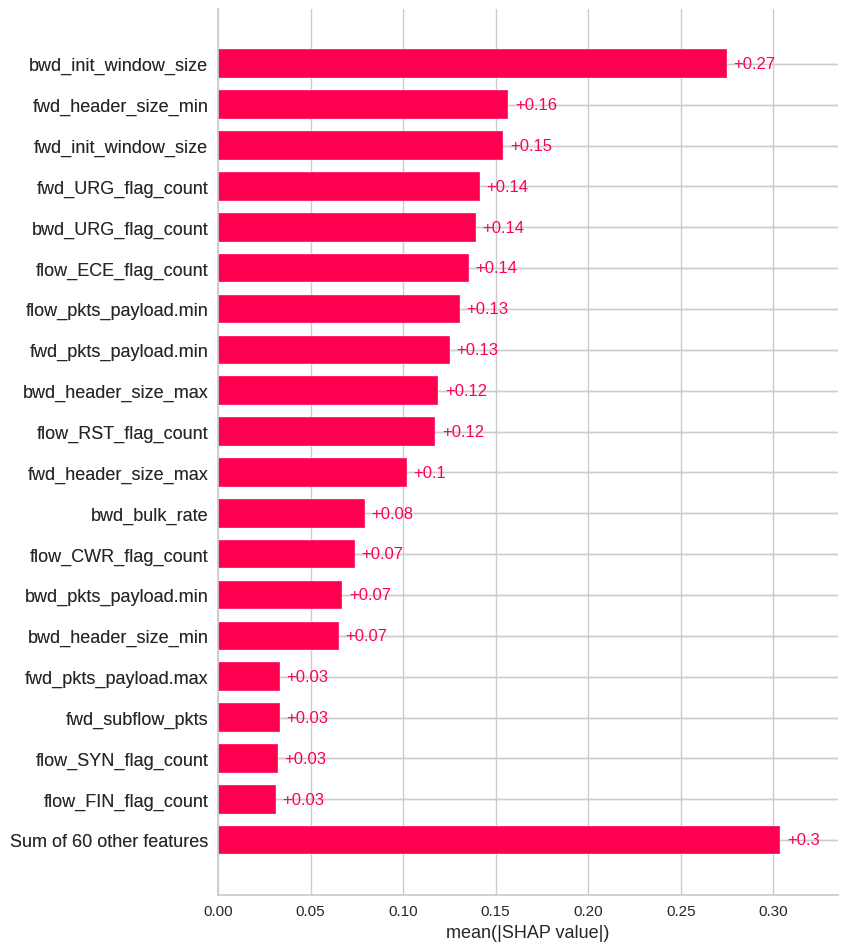

In [19]:
exp = Explanation(sv[0],
              explainer.expected_value[0],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

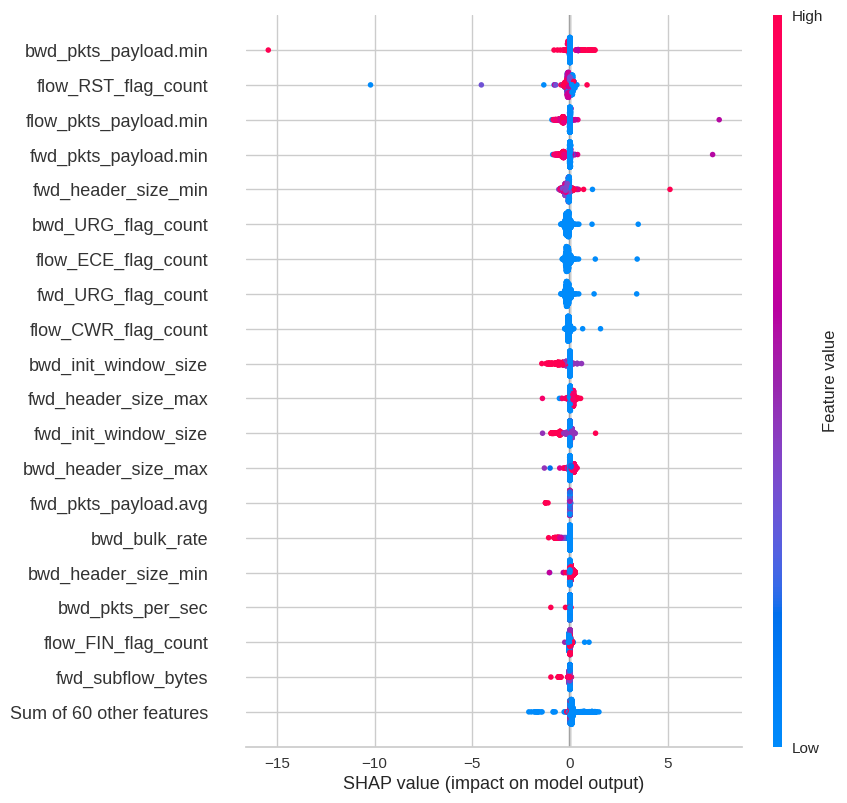

In [20]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

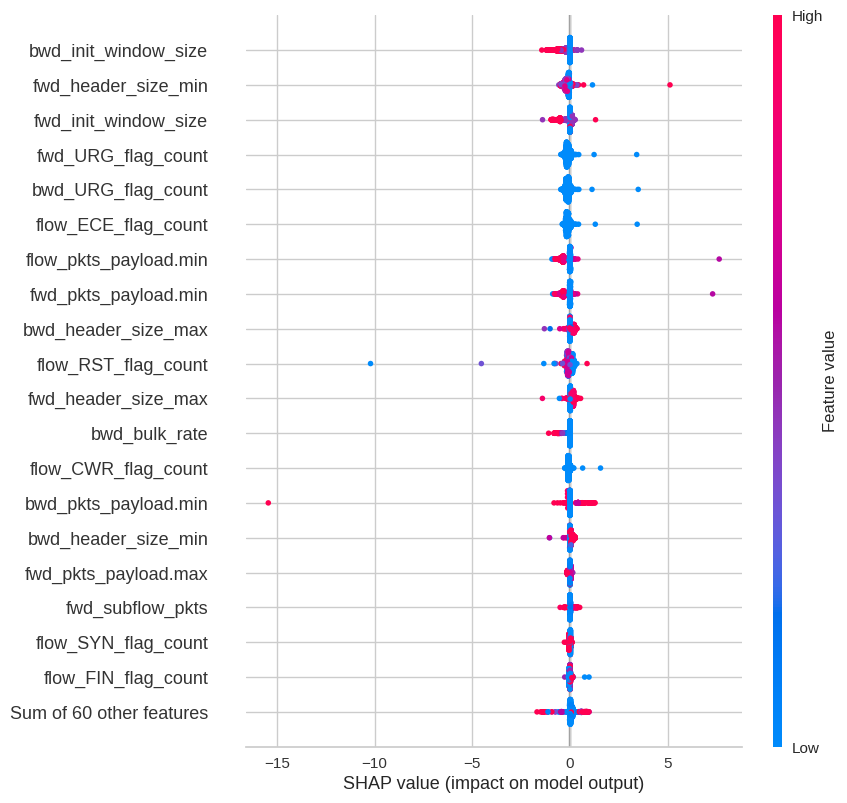

In [21]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Bening shap

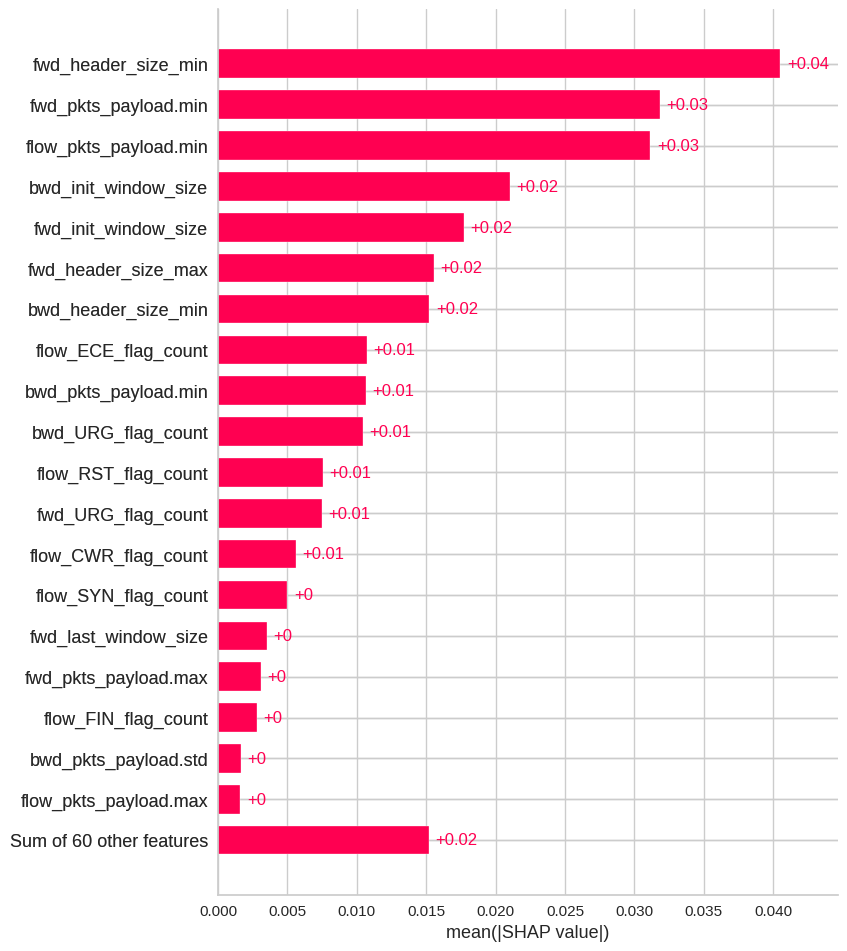

In [22]:
exp = Explanation(sv[1],
              explainer.expected_value[1],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

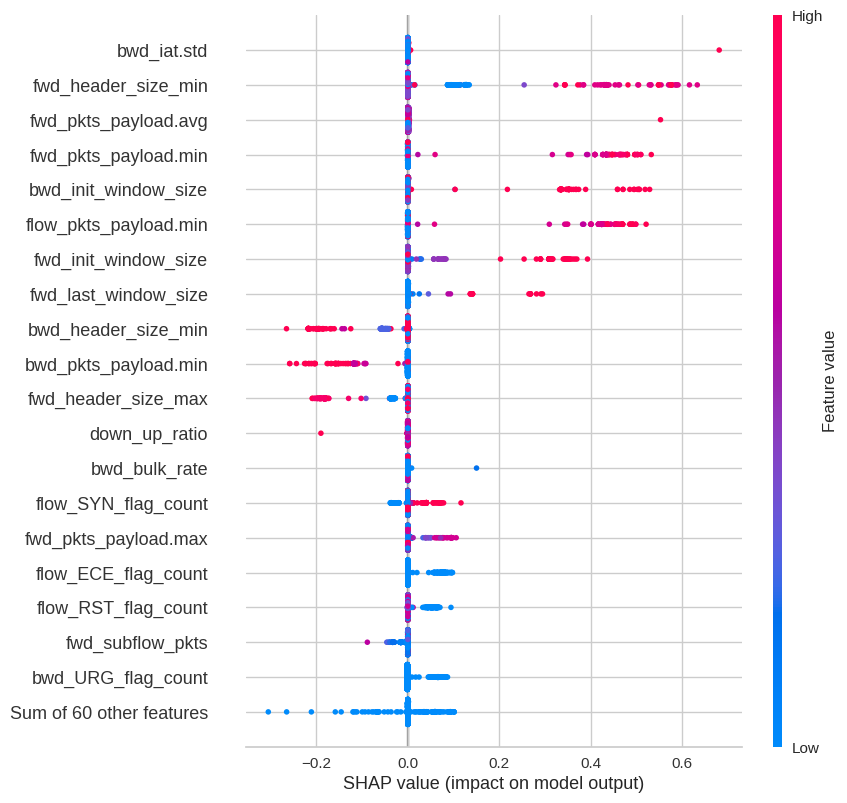

In [23]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

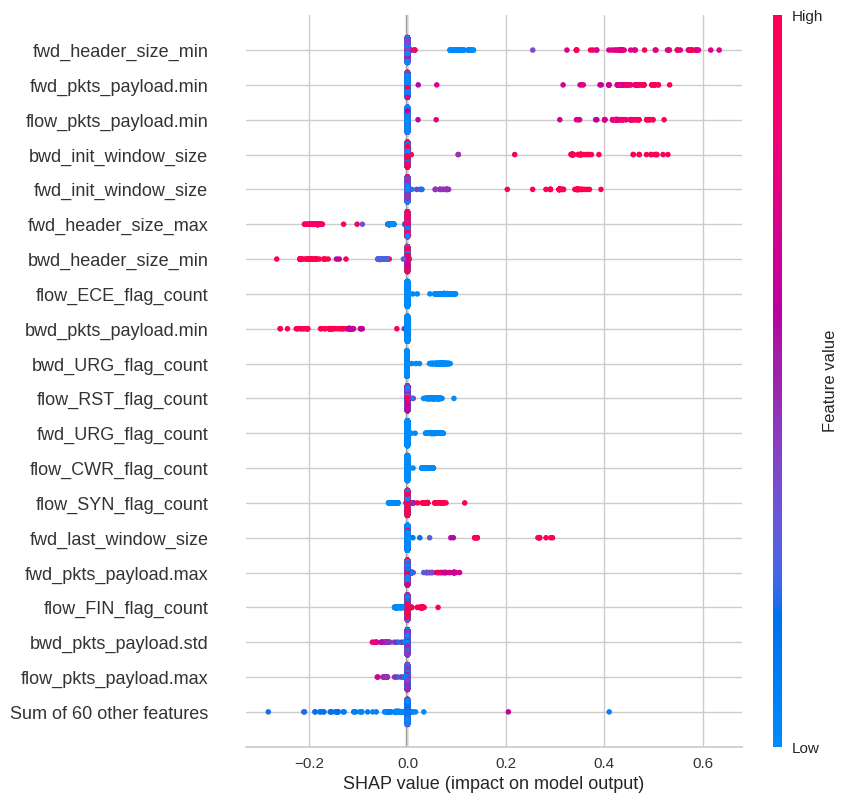

In [24]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Bruteforce shap

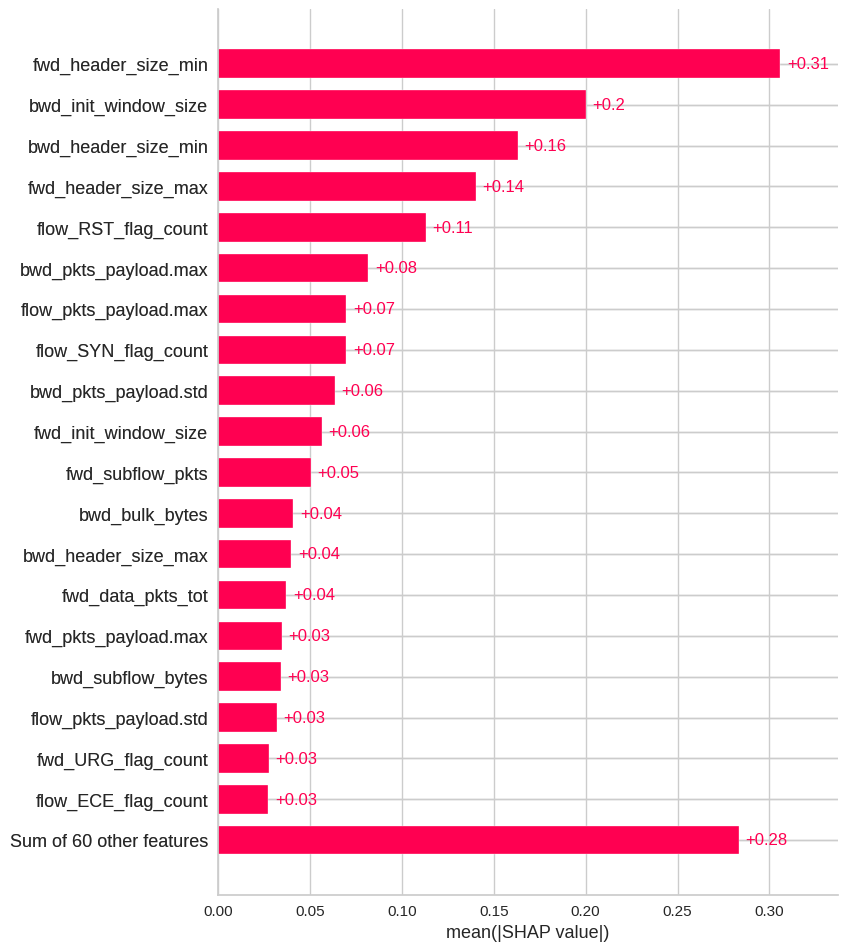

In [25]:
exp = Explanation(sv[2],
              explainer.expected_value[2],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

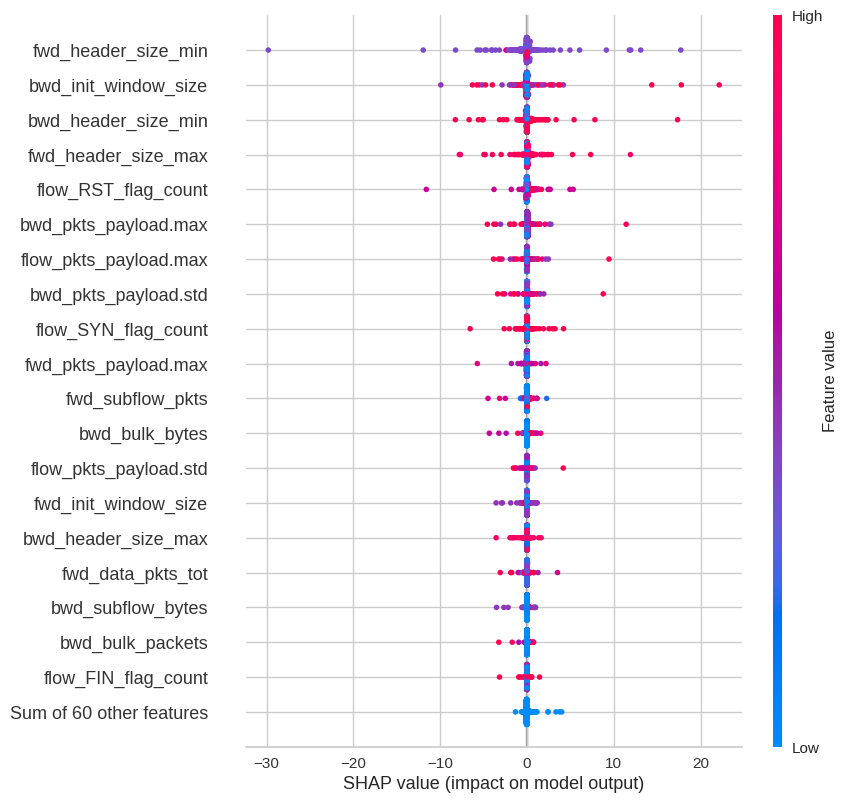

In [26]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

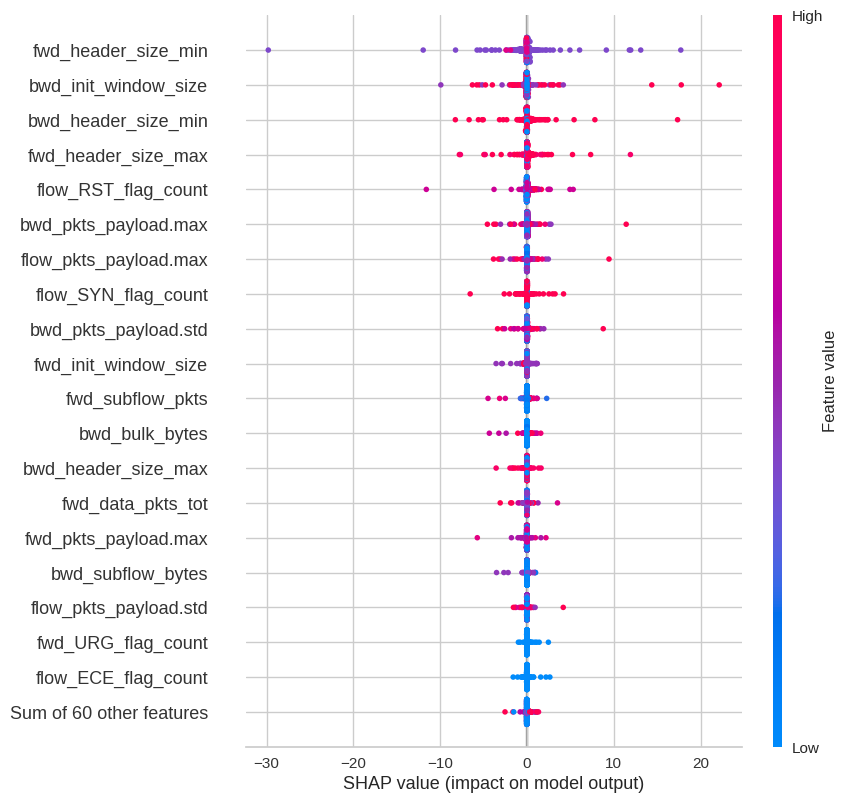

In [27]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Bruteforce XML shap

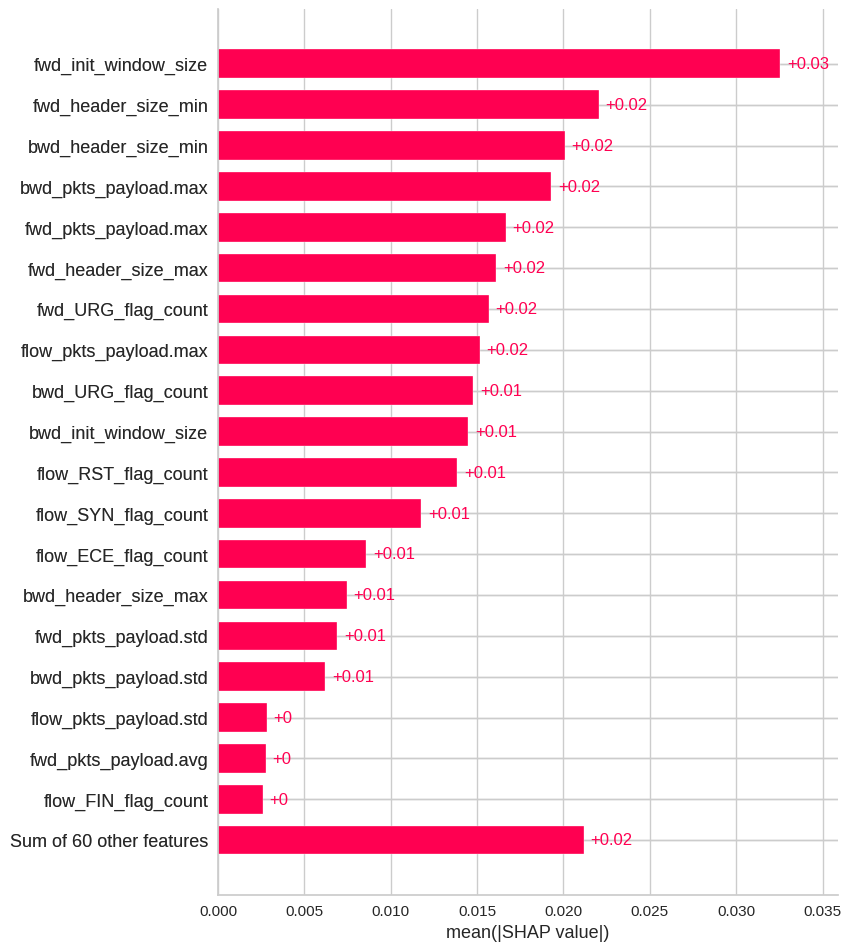

In [28]:
exp = Explanation(sv[3],
              explainer.expected_value[3],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

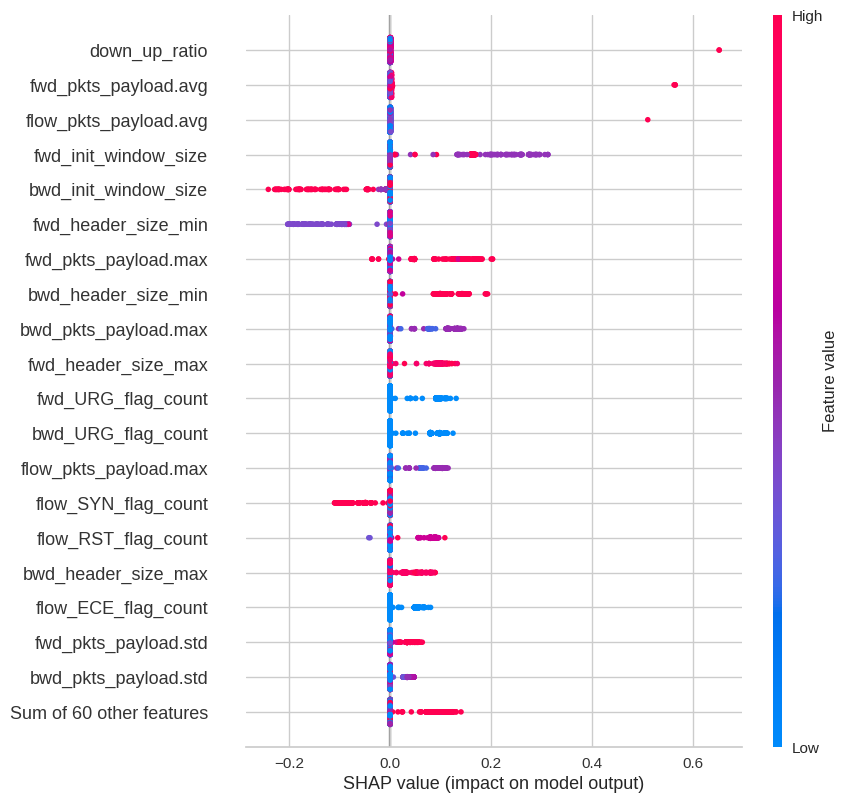

In [29]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

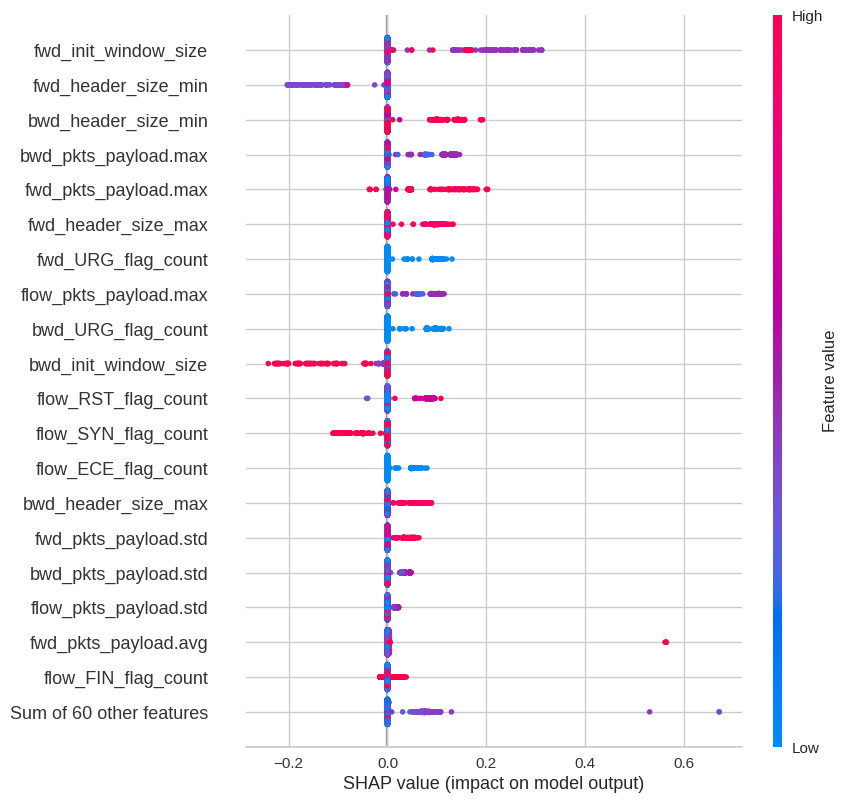

In [30]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Probing shap

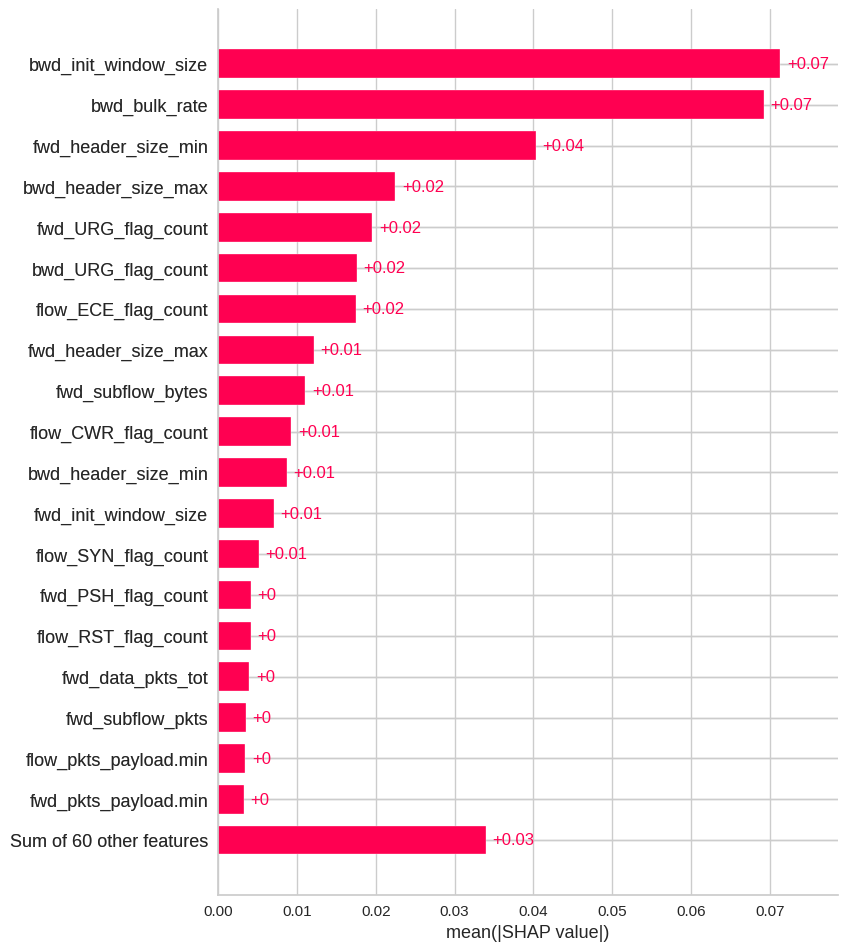

In [31]:
exp = Explanation(sv[4],
              explainer.expected_value[4],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

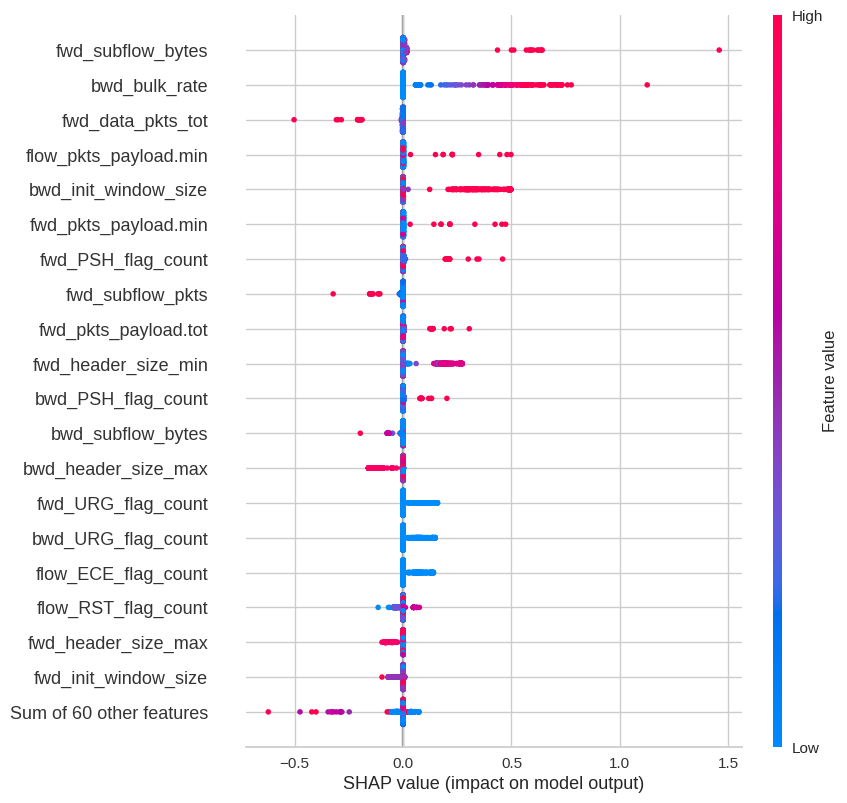

In [32]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

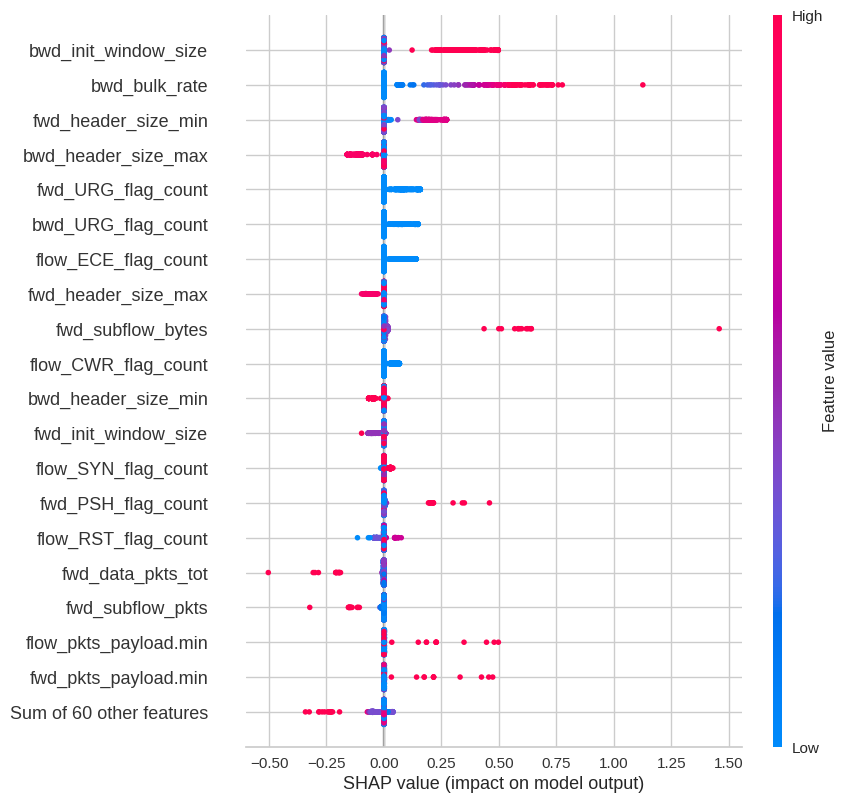

In [33]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Miner shap

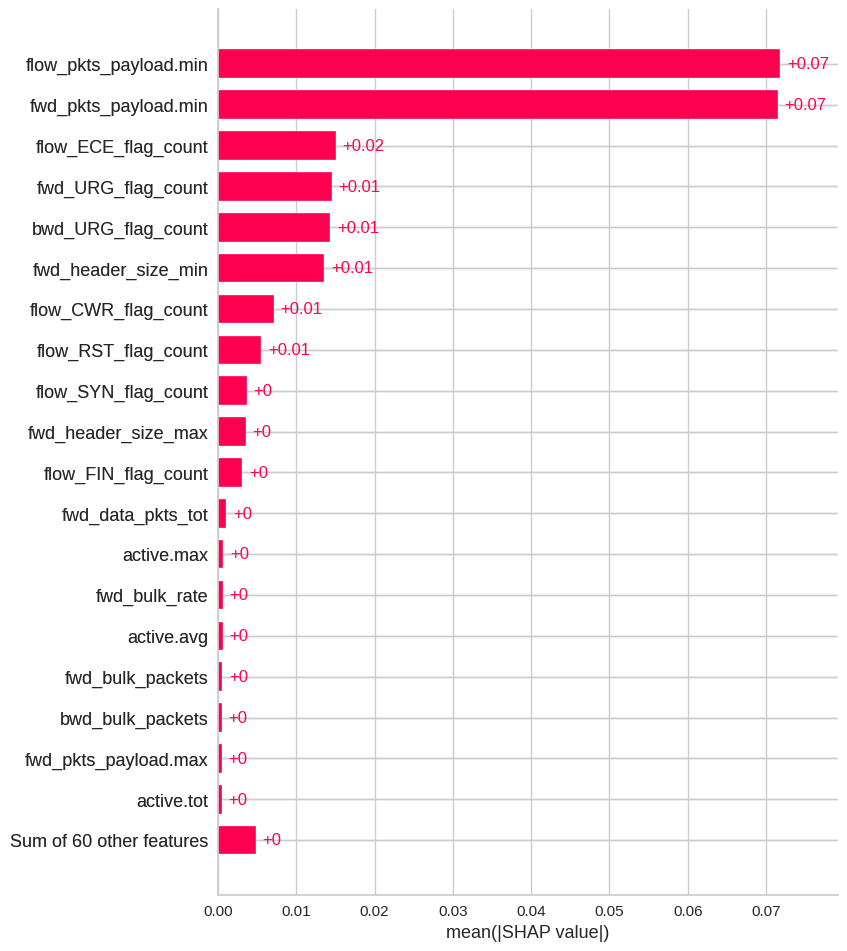

In [34]:
exp = Explanation(sv[5],
              explainer.expected_value[5],
              data=foreground, 
              feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
plt.show()

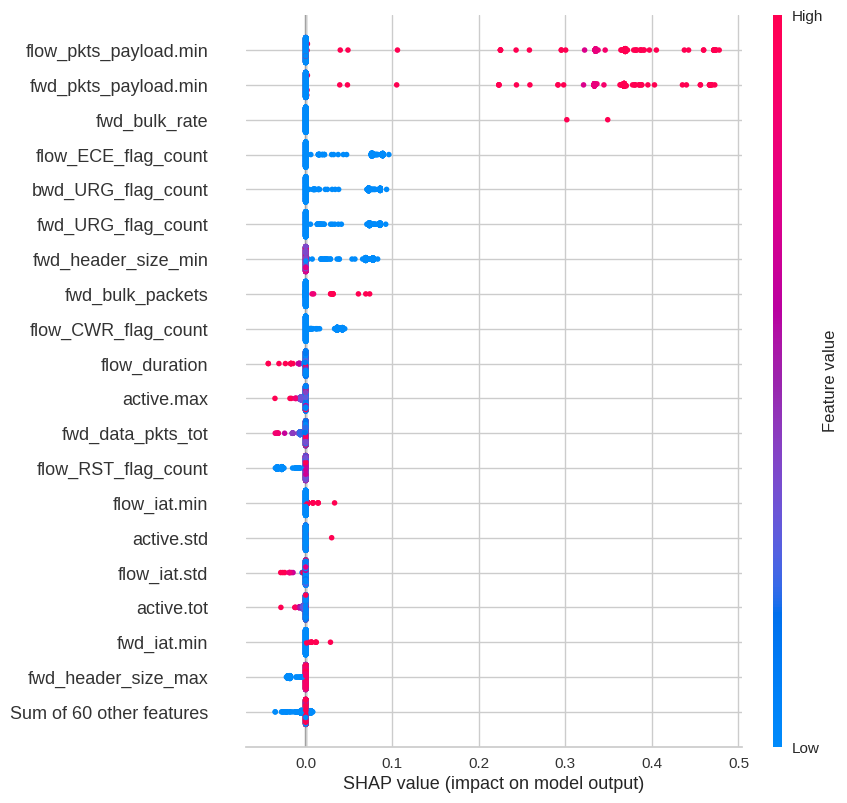

In [35]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

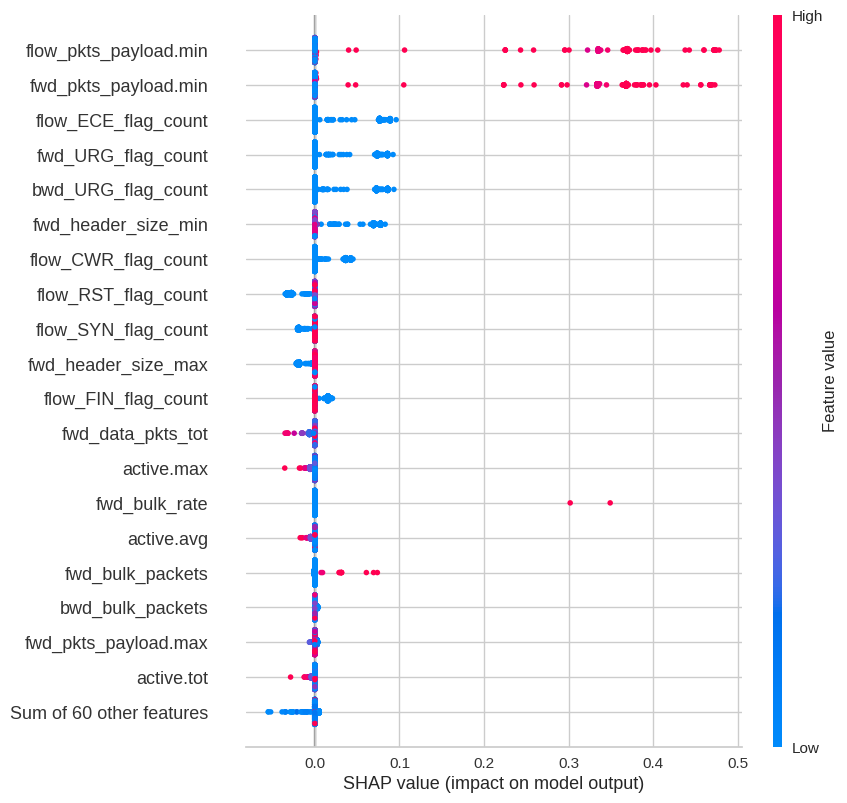

In [36]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

# Zero day test

In [37]:
classes = sorted(pd.unique(ds['traffic_category']).tolist())

In [38]:
y_train_attack = y_train[y_train != 2]
X_train_attack = X_train[y_train != 2]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  10.746024370193481


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.840135,0.703526
1,PRECISION,0.833704,0.604561
2,RECALL,0.840135,0.703526
3,F1 SCORE,0.830430,0.648537


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


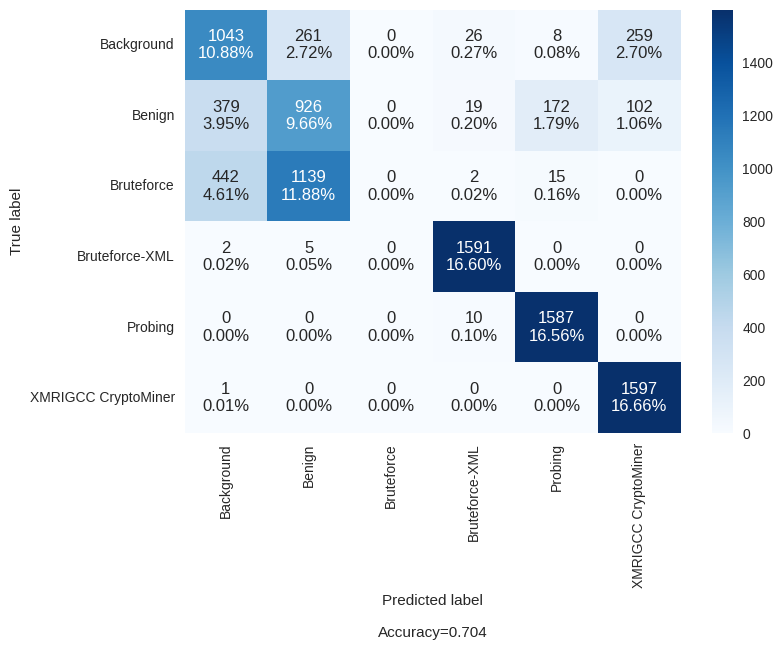

In [39]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [40]:
y_train_attack = y_train[y_train != 3]
X_train_attack = X_train[y_train != 3]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  55.324341773986816


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.820043,0.683705
1,PRECISION,0.818553,0.624886
2,RECALL,0.820043,0.683705
3,F1 SCORE,0.811379,0.638407


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


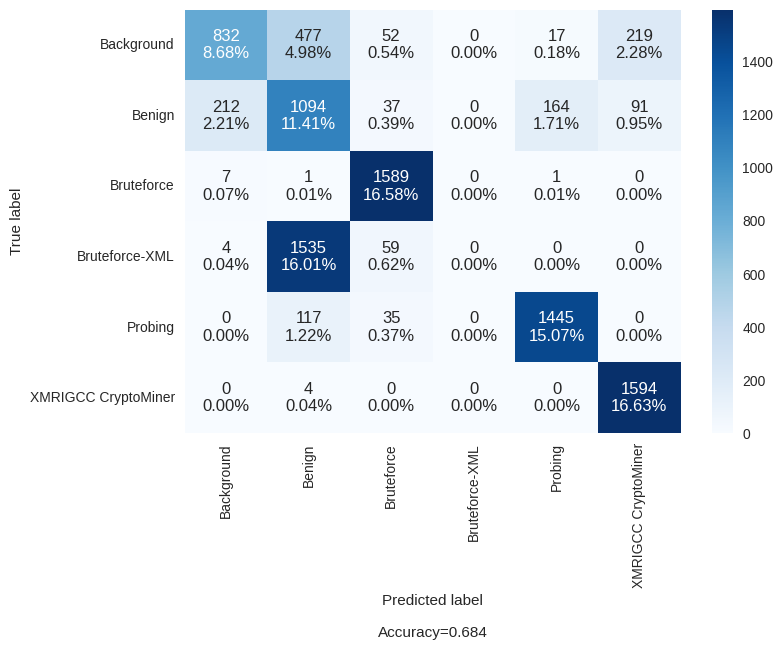

In [41]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [42]:
y_train_attack = y_train[y_train != 4]
X_train_attack = X_train[y_train != 4]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  7.257031679153442


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.844387,0.710411
1,PRECISION,0.838747,0.620985
2,RECALL,0.844387,0.710411
3,F1 SCORE,0.836634,0.657388


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


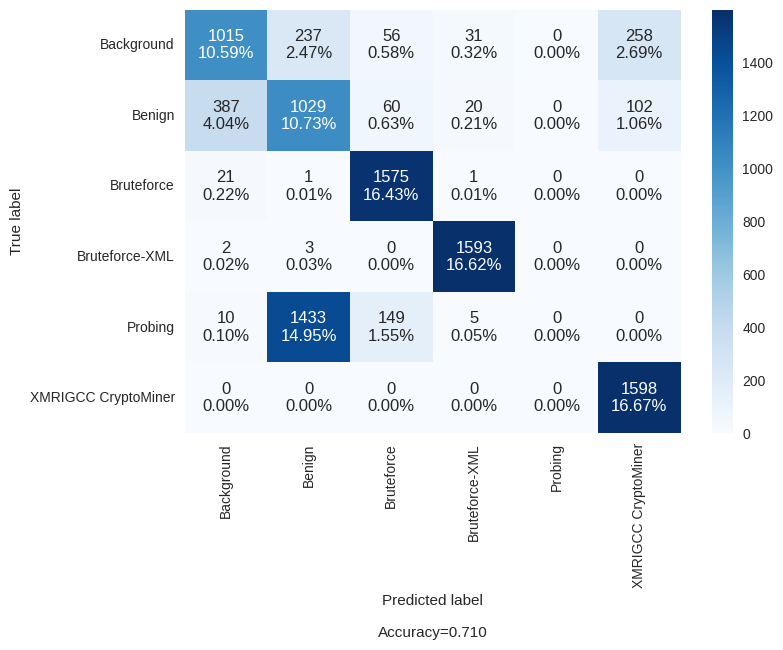

In [43]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [44]:
y_train_attack = y_train[y_train != 5]
X_train_attack = X_train[y_train != 5]
model.fit(X_train_attack, y_train_attack)
y_predicted_train = model.predict(X_train_attack)
y_predicted_test = model.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

No improvement for 10 epochs, stopping.
Execution time:  55.918851375579834


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Measure,Train,Test
0,ACCURACY,0.840292,0.696850
1,PRECISION,0.856302,0.659148
2,RECALL,0.840292,0.696850
3,F1 SCORE,0.824361,0.646135


unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


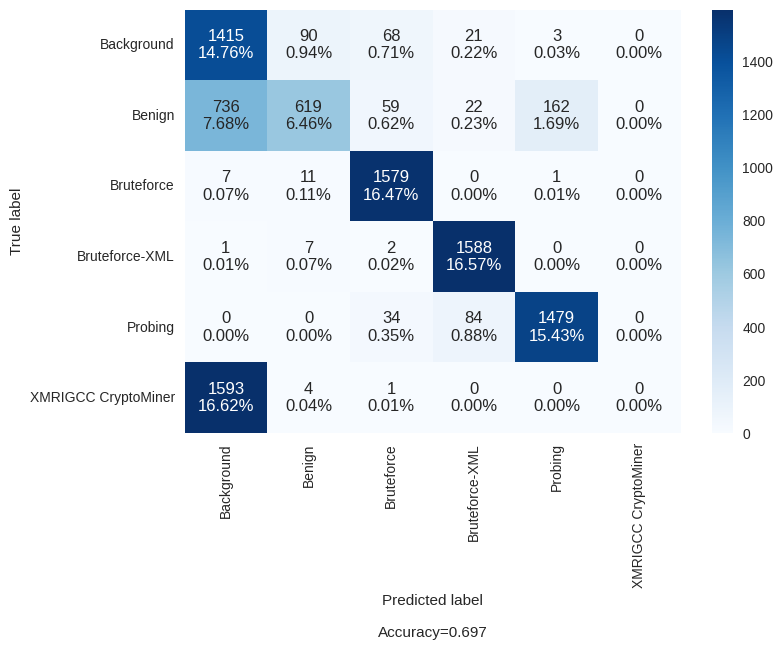

In [45]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')